## detect objects from microscopic images

This code is for google colaboratory. Check that **GPU is available** before running this code

In [1]:
!nvidia-smi

Mon Apr 18 05:01:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import os
os.chdir('/content/drive/My Drive/ai_ichthyolith/')

Mounted at /content/drive


In [3]:
!pip install keras==2.3.1
%tensorflow_version 1.x
!pip install h5py==2.10.0

     |████████████████████████████████| 377 kB 8.3 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.3.1 which is incompatible.
TensorFlow 1.x selected.
     |████████████████████████████████| 2.9 MB 7.3 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


In [4]:
# make some noise after training
# https://qiita.com/skiing_LAL10/items/78be5e7aaaffe461c3ac (in Japanese)
from google.colab import output
def beep():
    output.eval_js('new Audio(\
    "https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
    .play()') 

## Initial settings

In [5]:
site_name = 'Site_U1370'
sample_ID = 'U1370D_08_CC_22' # key of image filenames

BASE_DIR_NAME = '20211219_dataset1' # select the directory of best model

best_epoch = 80
class_names = ['bg', 'tooth']

###############################################

ROOT_DIR = '/content/drive/My Drive/ai_ichthyolith/' # on google colab, absolute path should be specified
assert os.path.exists(f"{ROOT_DIR}/data/images/{site_name}/{sample_ID}")
stride = 640 # width and heights of the square image (in pixel)
DEVICE = '/gpu:0' # '/cpu:0' or '/gpu:0'
MAX_GT_INSTANGES = 75
pixel2micron = 0.96 # micrometer 後で確認

### libraries and paths

In [6]:
MODEL_NAME = 'mask_rcnn_ichthyolith_{:0=4}.h5'.format(best_epoch)
# TEST_DATASET_DIR = ROOT_DIR + 'data/images/test'
hirox_dir = ROOT_DIR + 'data/images'

import os
import sys
import time
import math
from glob import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imsave
from PIL import Image, ImageOps
Image.MAX_IMAGE_PIXELS = 1000000000

sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn import model as modellib
from mrcnn.config import Config

from functions.utils import load_pickle, save_pickle
from functions.detect import detect
%matplotlib inline

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
DETECTIONS_DIR = os.path.join(ROOT_DIR, 'results')
TEST_MODE = 'inference'

MODEL_PATH = os.path.join(MODEL_DIR, BASE_DIR_NAME, MODEL_NAME)
assert os.path.exists(MODEL_PATH)
DETECTIONS_DIR = os.path.join(DETECTIONS_DIR, BASE_DIR_NAME, MODEL_NAME[-7:-3])

annot_base_dir = f'{ROOT_DIR}data/annotations/{sample_ID}/'
os.makedirs(annot_base_dir, exist_ok = True)

Using TensorFlow backend.


### overwriting Config

In [7]:
class InferenceConfig(Config):
    """Configuration for detecting ichthyolith in the give image."""
    # Give the configuration a recognizable name
    NAME = 'ichthyolith'
    
    # Batch size  GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = len(class_names)
    
    # Skip detections with < DETECTION_MIN_CONFIDENCE
    DETECTION_MIN_CONFIDENCE = 0
    
    # change IMAGE_MIN_DIM and IMAGE_MAX_DIM according to the model version
    IMAGE_MIN_DIM = stride
    IMAGE_MAX_DIM = stride
    
    MAX_GT_INSTANGES = MAX_GT_INSTANGES
    TRAIN_ROI_PER_IMAGE = 400
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

### テスト画像の検出

In [ ]:
# load model
model = modellib.MaskRCNN(mode="inference", 
                          config=InferenceConfig(),
                          model_dir=MODEL_DIR)
model.load_weights(MODEL_PATH, by_name=True)

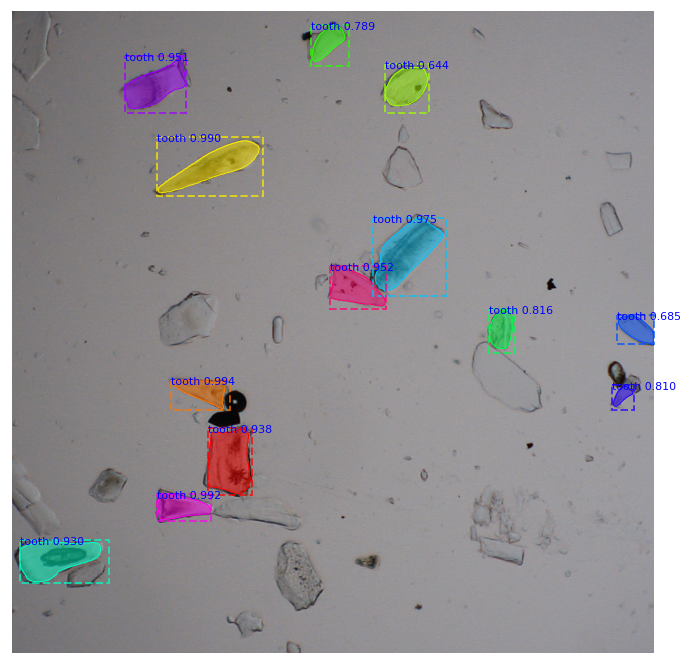

In [10]:
# os.chdir(TEST_DATASET_DIR)
testImg_path = os.path.join(hirox_dir, '1179C_24_05_75_004_7680_9600.jpg')
ignore_classids = []



img = imread(testImg_path)

filename = testImg_path.split('/')[-1]
result = detect(model, img, filename, ignore_classids = ignore_classids)
scores = result['scores']
bbox = result['rois']
masks = result['masks']
class_ids = result['class_ids']

# # show images by class
# for i, cl in enumerate(class_names):
#     if cl != 'bg':
#         bbox_cl = bbox[class_ids == i]
#         masks_cl = masks[:, :, class_ids == i]
#         class_ids_cl = class_ids[class_ids == i]
#         scores_cl = scores[class_ids == i]    
#         visualize.display_instances(img, bbox_cl, masks_cl, class_ids_cl, 
#                                 class_names, scores=scores_cl, title = f'class: {cl}', figsize=[8, 8])

fig, ax = plt.subplots(1,1, figsize= [12, 12])        
visualize.display_instances(img, bbox, masks, class_ids, 
                            class_names, scores, ax=ax)
# plt.savefig('example1.jpg')
plt.show()

# # crop detected objects
# for i, (y1, x1, y2, x2) in enumerate(bbox):
#     cropped = img[max(y1-30, 0):min(y2+30, 1200), max(x1-30, 0):min(x2+30, 1200)]
#     imsave(f"detection{i:0=2}.jpg", cropped)

### detection of slide images

In [ ]:
# ROOT_DIR
sorted(glob(f"{ROOT_DIR}/data/images/{site_name}/{sample_ID}/*"))

['/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_001',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_002',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_003',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_004',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_005',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_006',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_007',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_008',
 '/content/drive/My Drive/ai_ichthyolith//data/images/hirox/Site_U1370/U1370D_08_CC_22/U1370D_08_CC_22_009',
 '/content/drive/My

In [ ]:
slide_No = None
# slide_No = [7, 8]
ignore_classids = []

###############################################

from functions.detect import batch_detect_microscopes
hirox_img_dir = os.path.join(hirox_dir, site_name, sample_ID)
assert os.path.exists(hirox_img_dir), hirox_img_dir
batch_detect_microscopes(MODEL_PATH, hirox_img_dir, config, DETECTIONS_DIR,
                         device=DEVICE, time_output=False, ignore_classids = ignore_classids, 
                         save_points = True, save_mask = False, slide_No=slide_No)
beep()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights /content/drive/My Drive/ai_ichthyolith/models/20211219_dataset1/mask_rcnn_ichthyolith_0080.h5
following slide will be detected
['U1370D_08_CC_22_001', 'U1370D_08_CC_22_002', 'U1370D_08_CC_22_003', 'U1370D_08_CC_22_004', 'U1370D_08_CC_22_005', 'U1370D_08_CC_22_006', 'U1370D_08_CC_22_007', 'U1370D_08_CC_22_008', 'U1370D_08_CC_22_009', 'U1370D_08_CC_22_010', 'U1370D_08_CC_22_011', 'U1370D_08_CC_22_012', 'U1370D_08_CC_22_013', 'U1370D_08_CC_22_014', 'U1370D_08_CC_22_015', 'U1370D_08_CC_22_016']

start detecting.
slide name: U1370D_08_CC_22_001

530/532
elapsed time: 154 [sec]
saved: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_001.pkl

s

### process data

In [ ]:
from functions.utils import load_json, load_pickle
from functions.process_excel import ExcelDataProcessor
from functions.process_pickle import batch_convert_to_eval_format

In [ ]:
base_pickle_dir = f"{ROOT_DIR}results/{BASE_DIR_NAME}/{best_epoch:0=4}"
os.chdir(base_pickle_dir)
print('following pickles file exist\n')
path_list = sorted(glob(os.path.join(base_pickle_dir, f"{sample_ID}*.pkl")))
path_list

following pickles file exist



['/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_001.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_002.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_003.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_004.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_005.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_006.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_007.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_008.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_009.pkl',
 '/content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_010.pkl',
 '/content/drive/My 

In [ ]:
# non maximum suppression

display_detail = False
slide_No = None
# slide_No = list(range(1, 11 + 1))
# slide_No = slide_No
# use_pickle_names = 'MR15_E01_PC11_24_05_26_029'

###############################################

if slide_No is None:
    use_pickle_names = sample_ID
else:
    use_pickle_names = [f'{sample_ID}_{num:0=3}.pkl' for num in slide_No]

if use_pickle_names == 'all':
    os.chdir(base_pickle_dir)
    use_pickle_names = [pk for pk in glob('*.pkl') if 'final_evaluation' not in pk]
elif type(use_pickle_names) == str:
    os.chdir(base_pickle_dir)
    use_pickle_names = [pk for pk in glob(use_pickle_names + '*.pkl') if 'final_evaluation' not in pk]
use_pickle_names.sort()
print("use_pickle_names:", use_pickle_names)

path_list = [path for path in path_list if os.path.basename(path) in use_pickle_names]

# path_list = ['/content/drive/My Drive/ai_ichthyolith/results/logs_dataset_tooth_denticle_with_handpicked_20200723/0080/MR15_PC11_24_04_26_009.pkl',
#  '/content/drive/My Drive/ai_ichthyolith/results/logs_dataset_tooth_denticle_with_handpicked_20200723/0080/MR15_PC11_24_04_26_010.pkl',]


save_pickle_path = os.path.join(base_pickle_dir, f'{sample_ID}_final_evaluation.pkl')

eval_data = batch_convert_to_eval_format(path_list, save_path=save_pickle_path, 
                                         save_croppedName = True, rois_dtype = 'int32')

if display_detail:
    print()
    print(f'eval_data size     : {len(eval_data)}')
    for i in range(len(eval_data)):
        print(f'filename           : {eval_data[i][0]["filename"]}')
        print(f'shape of rois      : {eval_data[i][0]["rois"].shape}')
        print(f'dtype of rois      : {eval_data[i][0]["rois"].dtype}')
        print(f'shape of masks     : {eval_data[i][0]["masks"].shape}')
        print(f'dtype of masks     : {eval_data[i][0]["masks"].dtype}')
        print(f'shape of class_ids : {eval_data[i][0]["class_ids"].shape}')
        print(f'dtype of class_ids : {eval_data[i][0]["class_ids"].dtype}')
        print(f'shape of scores    : {eval_data[i][0]["scores"].shape}')
        print(f'dtype of scores    : {eval_data[i][0]["scores"].dtype}')
        print(f'rois               : {eval_data[i][0]["rois"][:5, :]}')
        print()

use_pickle_names: ['U1370D_08_CC_22_001.pkl', 'U1370D_08_CC_22_002.pkl', 'U1370D_08_CC_22_003.pkl', 'U1370D_08_CC_22_004.pkl', 'U1370D_08_CC_22_005.pkl', 'U1370D_08_CC_22_006.pkl', 'U1370D_08_CC_22_007.pkl', 'U1370D_08_CC_22_008.pkl', 'U1370D_08_CC_22_009.pkl', 'U1370D_08_CC_22_010.pkl', 'U1370D_08_CC_22_011.pkl', 'U1370D_08_CC_22_012.pkl', 'U1370D_08_CC_22_013.pkl', 'U1370D_08_CC_22_014.pkl', 'U1370D_08_CC_22_015.pkl', 'U1370D_08_CC_22_016.pkl']

removed 82 rois by non maximum suppression.
before: 359
after : 277

removed 153 rois by non maximum suppression.
before: 642
after : 489

removed 200 rois by non maximum suppression.
before: 795
after : 595

removed 190 rois by non maximum suppression.
before: 775
after : 585

removed 292 rois by non maximum suppression.
before: 1083
after : 791

removed 304 rois by non maximum suppression.
before: 1089
after : 785

removed 245 rois by non maximum suppression.
before: 996
after : 751

removed 230 rois by non maximum suppression.
before: 908


### inspect retults

In [ ]:
MODEL_PATH = os.path.join(MODEL_DIR, BASE_DIR_NAME, MODEL_NAME)
DETECTIONS_PATH = os.path.join(DETECTIONS_DIR, f'{sample_ID}_final_evaluation.pkl')
# GTS_PATH = f'/content/drive/My Drive/ai_ichthyolith/results/gts/{sample_ID}_final_eval_gts.pkl'

print(f'MODEL_PATH      : {os.path.exists(MODEL_PATH)}: {MODEL_PATH}')
print(f'DETECTIONS_PATH : {os.path.exists(DETECTIONS_PATH)}: {DETECTIONS_PATH}')
# print(f'GTS_PATH        : {os.path.exists(GTS_PATH)}: {GTS_PATH}')

MODEL_PATH      : True: /content/drive/My Drive/ai_ichthyolith/models/20211219_dataset1/mask_rcnn_ichthyolith_0080.h5
DETECTIONS_PATH : True: /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_hirox_final_evaluation.pkl


In [ ]:
from functions.process_pickle import extract_by_scores, extract_specific_size

score_threshold = 0
# score_threshold = score_threshold
min_size = None
max_size = None
classes = ['bg', 'tooth', 'denticle']

detections = load_pickle(DETECTIONS_PATH)
detections = extract_by_scores(detections, score_threshold)

# gts = load_pickle(GTS_PATH)

# gts = extract_specific_size(gts, min_size=min_size, max_size=max_size)

num_detections = [0 for _ in range(len(classes))]
# num_gts = [0 for _ in range(len(classes))]

for i in range(len(detections)):
    # assert detections[i][0]['filename'] == gts[i][0]['filename']
    class_ids = detections[i][0]['class_ids']
    # gt_class_ids = gts[i][0]['gt_class_id']
    num_detections_per_image = [0 for _ in range(len(classes))]
    # num_gts_per_image = [0 for _ in range(len(classes))]
    for class_id in class_ids:
        num_detections[class_id] += 1
        num_detections_per_image[class_id] += 1
    # for gt_class_id in gt_class_ids:
    #     num_gts[gt_class_id] += 1
    #     num_gts_per_image[gt_class_id] += 1
    print('\n---------------------------------------\n')
    print(f'detection ({detections[i][0]["filename"]})')
    for idx, c in enumerate(classes):
        print(f'{c:8}: {num_detections_per_image[idx]}')
    print()
    # print(f'gts ({gts[i][0]["filename"]})')
    # for idx, c in enumerate(classes):
    #     print(f'{c:8}: {num_gts_per_image[idx]}')
        
print('\n=======================================\n')

print('detection (total)')
for idx, c in enumerate(classes):
    print(f'{c:8}: {num_detections[idx]}')

print()
# print('gts (total)')
# for idx, c in enumerate(classes):
#     print(f'{c:8}: {num_gts[idx]}')

print('\n=======================================\n')


---------------------------------------

detection (U1370D_08_CC_22_001.jpg)
bg      : 0
tooth   : 277
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_002.jpg)
bg      : 0
tooth   : 489
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_003.jpg)
bg      : 0
tooth   : 595
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_004.jpg)
bg      : 0
tooth   : 585
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_005.jpg)
bg      : 0
tooth   : 791
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_006.jpg)
bg      : 0
tooth   : 785
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_007.jpg)
bg      : 0
tooth   : 751
denticle: 0


---------------------------------------

detection (U1370D_08_CC_22_008.jpg)
bg      : 0
tooth   : 678
denticle: 0


---------------------------------------

detection (U1370D_08_C

In [ ]:
def generateImg_from_crop(crop_img, box, filename, margin = 30):
    """
    box : y_min, x_min, y_max, x_max
    """
    y0, x0 = map(int, filename[:-4].split('_')[-2:])
    y_start = max(box[0] - y0 - margin, 0)
    y_end = min(box[2] - y0 + margin, crop_img.shape[0])
    x_start = max(box[1] - x0 - margin, 0)
    x_end = min(box[3] - x0 + margin, crop_img.shape[1])
    trimmed_img = crop_img[y_start:y_end, x_start:x_end]
    savename = f'{filename[:-4]}_{y_start}_{x_start}.jpg'
    return(trimmed_img, savename)

In [ ]:
score_threshold = 0

In [ ]:
from functions.annotation import _get_length, _get_size

In [ ]:
pixel2micron

0.96

In [ ]:
from functions.process_pickle import get_top_left_coordinate

data = load_pickle(DETECTIONS_PATH)
df_detect = pd.DataFrame()
index = 1
for j in range(len(data)):
    original_slide_name = data[j][0]['filename']
    for i, roi in enumerate(data[j][0]['rois']):
        df_detect.loc[index, 'id'] = index
        df_detect.loc[index, 'original_slide_name'] = original_slide_name
        df_detect.loc[index, 'x_min'] = roi[1]
        df_detect.loc[index, 'y_min'] = roi[0]
        df_detect.loc[index, 'x_max'] = roi[3]
        df_detect.loc[index, 'y_max'] = roi[2]

        if 'all_points_xs' in data[j][0].keys():
            all_points_x = data[j][0]['all_points_xs'][i]
            all_points_y = data[j][0]['all_points_ys'][i]
            if all_points_x.shape[0] > 15:
                step = len(all_points_x) // 15
                all_points_x = all_points_x[::step]
                all_points_y = all_points_y[::step]
            df_detect.loc[index, 'all_points_x'] = ', '.join(map(str, all_points_x.tolist()))
            df_detect.loc[index, 'all_points_y'] = ', '.join(map(str, all_points_y.tolist()))
            
            # todo: length と size は同時に取得
            df_detect.loc[index, 'length'] = _get_length(all_points_x, all_points_y, pixel2micron=pixel2micron)
            df_detect.loc[index, 'size'] = _get_size(all_points_x, all_points_y, pixel2micron=pixel2micron)
            for col in ['mode', 'class']:
                df_detect.loc[index, col] = np.nan
        else:
            for col in ['all_points_x', 'all_points_y', 'size', 'length', 'mode', 'class']:
                df_detect.loc[index, col] = np.nan

        df_detect.loc[index, 'detected_class'] = class_names[data[j][0]['class_ids'][i]]
        df_detect.loc[index, 'score'] = data[j][0]['scores'][i]
        if 'cropped_imgName' in data[j][0].keys():
            cropped_name = data[j][0]['cropped_imgName'][i]
            df_detect.loc[index, 'cropped_name'] = cropped_name
            rel_y, rel_x = get_top_left_coordinate(cropped_name)
            df_detect.loc[index, 'rel_x_min'] = roi[1] - rel_x
            df_detect.loc[index, 'rel_y_min'] = roi[0] - rel_y
            df_detect.loc[index, 'rel_x_max'] = roi[3] - rel_x
            df_detect.loc[index, 'rel_y_max'] = roi[2] - rel_y

        index += 1

df_detect.loc[:, ['id', 'x_min', 'y_min', 'x_max', 'y_max']] = df_detect.loc[:, ['id', 'x_min', 'y_min', 'x_max', 'y_max']].astype(int)
try:
    df_detect.loc[:, ['rel_x_min', 'rel_y_min', 'rel_x_max', 'rel_y_max']] = df_detect.loc[:, ['rel_x_min', 'rel_y_min', 'rel_x_max', 'rel_y_max']].astype(int)
except:
    pass

# limit detections by score
df_detect = df_detect[df_detect['score'] >= score_threshold]

save_excel_path = os.path.join(annot_base_dir, f'{sample_ID}_detections.xlsx')
df_detect.to_excel(save_excel_path)
print(len(df_detect), 'objects detected')
print(f'saved: {save_excel_path}')
df_detect.head()

# # download excel
# from google.colab import files
# files.download(save_excel_path)

beep()

6877 objects detected
saved: /content/drive/My Drive/ai_ichthyolith/data/annotations/U1370D_08_CC_22/U1370D_08_CC_22_detections.xlsx


In [ ]:
# remove pickele file to save storage
for pickle_path in path_list:
    if os.path.exists(pickle_path):
        os.remove(pickle_path)
        print('removed: ', pickle_path)

removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_001.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_002.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_003.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_004.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_005.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_006.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_007.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_008.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/20211219_dataset1/0080/U1370D_08_CC_22_009.pkl
removed:  /content/drive/My Drive/ai_ichthyolith/results/2021121